# Ignorar

In [ ]:
#hide
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [1]:
#hide
# from fastbook import *

# Guardar en Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Tabla de contenidos

- [1 - Librerías](#lib)
- [2 - Paths para proyecto](#path)
- [3 - Metadata](#meta)
- [4 - Carga de imágenes y metadata](#carga)
- [5 - Preprocesamieto de las imágenes](#prepro)
- [6 - Train/Test split](#traintest)
- [7 - Modelo](#model)

<a name='lib'></a>
## Librerías

In [ ]:
# !pip install fastai

In [1]:
from fastai.vision.all import *
from utils_ATSIA import *

import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

<a name='path'></a>
## Paths para proyecto

In [2]:
organos = ["AmpollaRectal", "Branquias", "Hepatopancreas", "Intestino", "Uropodo"]
grados = ["G0", "G1", "G2", "G3", "G4"]

#Necesitamos la cantidad de caracteres que cada nomenclatura tiene para cada órgano
organo_len = {"AmpollaRectal" : 10, "Branquias" : 25, "Hepatopancreas" : 27, "Intestino" : 27, "Uropodo" :4}

In [3]:
main_path = Path(os.getcwd()) #Cuando estemos en local
# main_path = "/content/drive/MyDrive/ATSIA" #Cuando usamos Google Drive
path = {}
path["data"] = {}
path["img"] = {}
path["metadata"] = {}

for organo in organos:
    path["data"][organo] = os.path.join(main_path, "data", organo, f"X_{organo}.npy")
    path["img"][organo] = os.path.join(main_path, "img", organo)
    path["metadata"][organo] = os.path.join(main_path, "metadata", organo, f"metadata_{organo}.csv")

In [4]:
#Por el momento vamos a utilizar solo el órgano Hepatopancreas
organo = "Hepatopancreas"

In [5]:
SIZE = 200

<a name='meta'></a>
## Metada

In [6]:
metadata = get_metadata(path = path["img"][organo], organo = organo, organo_len = organo_len)
metadata.to_csv(path_or_buf = path["metadata"][organo], index=False)
metadata.sample(3)

,img_name,labels
81,DT_G0-DC_G0-L_085-M_G3-N_G0.png,DT_G0 DC_G0 L_085 M_G3 N_G0
218,DT_G1-DC_G0-L_080-M_G1-N_G0.png,DT_G1 DC_G0 L_080 M_G1 N_G0
55,DT_G0-DC_G0-L_080-M_G0-N_G0 (11).png,DT_G0 DC_G0 L_080 M_G0 N_G0


<a name='carga'></a> 
## Carga de imágenes y metadata 

In [7]:
metadata_csv = pd.read_csv(path["metadata"][organo], sep = ",")
metadata_csv.sample(3)

,img_name,labels
392,DT_G2-DC_G0-L_030-M_G1-N_G4.png,DT_G2 DC_G0 L_030 M_G1 N_G4
247,DT_G1-DC_G1-L_060-M_G2-N_G4.png,DT_G1 DC_G1 L_060 M_G2 N_G4
260,DT_G1-DC_G1-L_070-M_G1-N_G0.png,DT_G1 DC_G1 L_070 M_G1 N_G0


### Constructing a DataBlock

In [9]:
# # check for mislabelled data
# b = []

# for i,v in enumerate(metadata_csv["labels"]):
#     a = v.split(" ")
#     for val in a:
#         if val not in b:
#             b.append(val)
# len(b)

In [44]:
def get_x(r): return Path(path["img"][organo], r['img_name'])
def get_y(r): return r['labels'].split(' ')


dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, 
                   get_y = get_y, 
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dsets = dblock.datasets(metadata_csv)
dsets.train[0]

(PILImage mode=RGB size=2210x2009,
 TensorMultiCategory([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [45]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#5) ['DC_G1','DT_G0','L_050','M_G0','N_G0']

And now we can display a sample of our data:

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


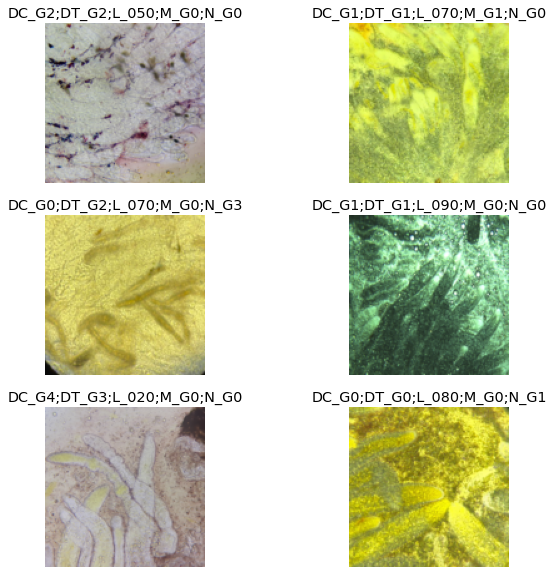

In [48]:
dls = dblock.dataloaders(metadata_csv)
dls.show_batch(nrows=3, ncols=2, figsize=(10,10))

Remember that if anything goes wrong when you create your `DataLoaders` from your `DataBlock`, or if you want to view exactly what happens with your `DataBlock`, you can use the `summary` method we presented in the last chapter.

Our data is now ready for training a model. As we will see, nothing is going to change when we create our `Learner`, but behind the scenes, the fastai library will pick a new loss function for us: binary cross-entropy.

### Binary Cross-Entropy

In [53]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time


KeyboardInterrupt: 

In [29]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10555674135684967,0.9323506951332092]

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

In [30]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10555674135684967,0.9432468414306641]

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [31]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it:

In [32]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9571)

We can now use this approach to find the best threshold level:

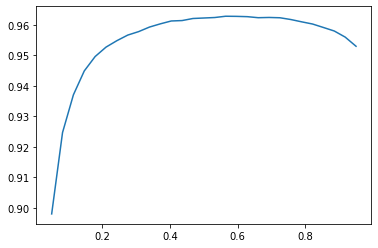

In [33]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

### Assemble the Data

We will use the [Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html) for this section. We'll begin by downloading the dataset as usual:

In [34]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [35]:
#hide
Path.BASE_PATH = path

Let's see what we've got!

In [36]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding *.obj* file for each (we won't need them here). Let's take a look inside one of these directories:

In [37]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Inside the subdirectories, we have different frames, each of them come with an image (*\_rgb.jpg*) and a pose file (*\_pose.txt*). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file:

In [38]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('15/frame_00229_pose.txt')

Let's take a look at our first image:

In [39]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

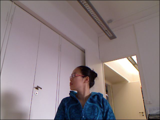

In [40]:
im.to_thumb(160)

The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [41]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [42]:
get_ctr(img_files[0])

tensor([314.3894, 308.6887])

We can pass this function to `DataBlock` as `get_y`, since it is responsible for labeling each item. We'll resize the images to half their input size, just to speed up training a bit.

One important point to note is that we should not just use a random splitter. The reason for this is that the same people appear in multiple images in this dataset, but we want to ensure that our model can generalize to people that it hasn't seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference from the previous data block examples is that the second block is a `PointBlock`. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images:

In [43]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

> important: Points and Data Augmentation: We're not aware of other libraries (except for fastai) that automatically and correctly apply data augmentation to coordinates. So, if you're working with another library, you may need to disable data augmentation for these kinds of problems.

Before doing any modeling, we should look at our data to confirm it seems okay:

/home/ubuntu/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


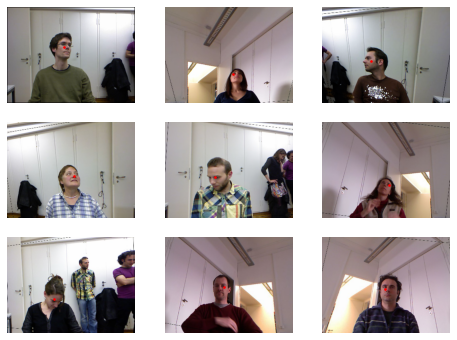

In [44]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

That's looking good! As well as looking at the batch visually, it's a good idea to also look at the underlying tensors (especially as a student; it will help clarify your understanding of what your model is really seeing):

In [45]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Make sure that you understand *why* these are the shapes for our mini-batches.

Here's an example of one row from the dependent variable:

In [46]:
yb[0]

TensorPoint([[0.2339, 0.2256]], device='cuda:0')

As you can see, we haven't had to use a separate *image regression* application; all we've had to do is label the data, and tell fastai what kinds of data the independent and dependent variables represent.

It's the same for creating our `Learner`. We will use the same function as before, with one new parameter, and we will be ready to train our model.

### Training a Model

As usual, we can use `cnn_learner` to create our `Learner`. Remember way back in <<chapter_intro>> how we used `y_range` to tell fastai the range of our targets? We'll do the same here (coordinates in fastai and PyTorch are always rescaled between -1 and +1):

In [47]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

`y_range` is implemented in fastai using `sigmoid_range`, which is defined as:

In [48]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

This is set as the final layer of the model, if `y_range` is defined. Take a moment to think about what this function does, and why it forces the model to output activations in the range `(lo,hi)`.

Here's what it looks like:

In [50]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

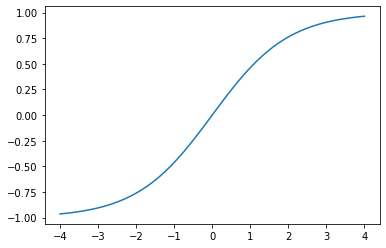

In [52]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

In [53]:
dls.loss_func

FlattenedLoss of MSELoss()

This makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean squared error loss) does. If you want to use a different loss function, you can pass it to `cnn_learner` using the `loss_func` parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root). 

We can pick a good learning rate with the learning rate finder:

SuggestedLRs(valley=0.0030199517495930195)

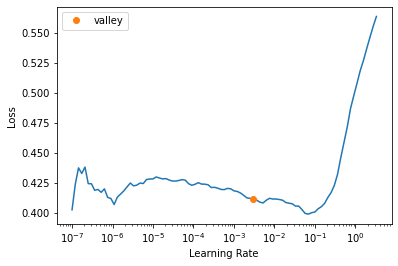

In [54]:
learn.lr_find()

We'll try an LR of 1e-2:

In [55]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.051653,0.005350,01:12


epoch,train_loss,valid_loss,time
0,0.008164,0.000553,01:26
1,0.002982,0.000103,01:22
2,0.001349,0.000069,01:22


Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:

In [56]:
math.sqrt(0.0001)

0.01

This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

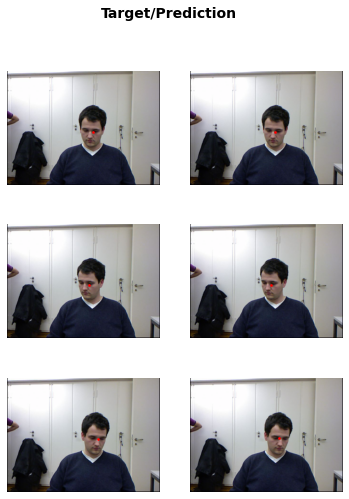

In [57]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

It's quite amazing that with just a few minutes of computation we've created such an accurate key points model, and without any special domain-specific application. This is the power of building on flexible APIs, and using transfer learning! It's particularly striking that we've been able to use transfer learning so effectively even between totally different tasks; our pretrained model was trained to do image classification, and we fine-tuned for image regression.

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression